# Problem Statement :
A US based housing company called surprise want to explore and enter Australia Housing market for purchase at low price and flip at higher price and provided 81 different variables and as part of study we need to identify which variables create the significant impact and how they impact price of house

## Steps followed 

##1. Identify the libraries required for data study and analysis and model bulding 
##2. Data cleanup  and exploration of data 
##3. Making the data ready for building the model 
##4. Data splitting into Train and Test Sets and doing necessary scaling 
##5. Creating the LR models and calculating the model accuracy , coefficients and Applying the model on test set.
##6 Create and Use regularization models with the help of Alpha for ridge and lasso
##7 Comparative analysis and selection of Best model and identify the variables. 

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# fetching the data from Local Drives (Housing Data)
Housing_data = pd.read_csv(r'C:\Users\vedachakravarthula\Downloads\train (1).csv')

In [3]:
# Importing required packages to perform the Data manipulation till building of model
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso  #### Build the Model and regularization
from sklearn.feature_selection import RFE #### Recurse features elimination to select the best features
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score

In [4]:
## Additionally setting display options as max 100 rows and columns
pd.set_option('display.max_column',None)
pd.set_option('display.max_row',None)
pd.set_option('precision',2)

In [5]:
Housing_data.shape

(1460, 81)

In [6]:
### Get the basic info of data 
Housing_data.info()
### Features types: float64  are (3), int64(35), object(43)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
## Similarly , based on study of other features we can drop below with specific reasons mentioned
Housing_data.isnull().sum().sort_values(ascending = False).head(25)
## Misc Features with 53 values 3.6% where classification of exisrence of Shed , Garages 1 or 2 does not create big impact.
## Alley Feature relating to Use of Gravel or paved for access to Housing consituting 6% does not creating impact on model evaluation
## fence existing of 281 properties 20% covering Min  Wiring  , Privacy factor does not create any noise on model
## We can go for  droping of these Features

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
Functional         0
Fireplaces         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
dtype: int64

In [8]:
### Let us see what is Percentage of Missing values and defined the details
def missingValueCount(data_frame,threshold):
    missing_value = data_frame.isnull().sum()
    return missing_value.loc[missing_value> threshold]

In [9]:
# To get the Percentages NA for each of features to see any elimination
def missingValuePercentages(data_frame,threshold):
    missing_value = round(Housing_data.isnull().sum()/len(Housing_data),2).sort_values(ascending = False)
    return missing_value.loc[missing_value>threshold]

In [10]:
## To update missing values with specific mean etc
def imputingMissingValue(data_frame,col,value):
    data_frame[col].fillna(value, inplace = True)

In [11]:
# Aligning the Years to dates fields
def yearToage(data_frame,col):
    new_year = col + '_old'
    data_frame[new_year] = data_frame[col].max()-Housing_data[col]

In [12]:
def dropOutliers(data_frame, numerical_columns):
    list = []
    for col in numerical_columns:
        Q1 = data_frame[col].quantile(.25)
        Q3 = data_frame[col].quantile(.99)
        IQR = Q3-Q1
        data_frame =  data_frame[(data_frame[col] >= (Q1-(1.5*IQR))) & (data_frame[col] <= (Q3+(1.5*IQR)))] 
    return data_frame

In [13]:
Housing_data.shape

(1460, 81)

In [14]:
Housing_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.0,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0
mean,730.50,56.9,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.2
std,421.61,42.3,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.5
min,1.00,20.0,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0
25%,365.75,20.0,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0
50%,730.50,50.0,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0
75%,1095.25,70.0,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0
max,1460.00,190.0,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.0


In [15]:
### let us see the columns
Housing_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [16]:
missingValueCount(Housing_data,0)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [17]:
## Removing the Outliers data 
missingValuePercentages(Housing_data,0)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

In [18]:
# Based on Features considering an data above 10% as missing
missing_data = missingValuePercentages(Housing_data,0.1)
missing_data

PoolQC         1.00
MiscFeature    0.96
Alley          0.94
Fence          0.81
FireplaceQu    0.47
LotFrontage    0.18
dtype: float64

In [19]:
Housing_data = Housing_data.drop(list(missing_data.index),axis='columns')

In [20]:
missingValuePercentages(Housing_data,0)

GarageType      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
GarageCond      0.06
BsmtFinType1    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType2    0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

In [21]:
# As we have Defined Converting the years into Age , lets convert into age , there are 4 Year related lets convert them
yearToage(Housing_data,'YearBuilt')
yearToage(Housing_data,'YearRemodAdd')
yearToage(Housing_data,'GarageYrBlt')
yearToage(Housing_data,'YrSold')

In [22]:
## Let us see how these columns looks like
Housing_data[['YearBuilt_old','YearRemodAdd_old','GarageYrBlt_old','YrSold_old']]

,YearBuilt_old,YearRemodAdd_old,GarageYrBlt_old,YrSold_old
0,7,7,7.0,2
1,34,34,34.0,3
2,9,8,9.0,2
3,95,40,12.0,4
4,10,10,10.0,2
5,17,15,17.0,1
6,6,5,6.0,3
7,37,37,37.0,1
8,79,60,79.0,2
9,71,60,71.0,2


In [23]:
## Lets drop the years as we converted Years into Age 
Housing_data = Housing_data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis=1)

In [24]:
Housing_data.isnull().sum().sort_values(ascending = False)
# Lets impur missing values with Highest Counts
###imputtingMissingvalue('Housing_data','GarageFinish','Unf') for example here Garage Finish Highest Count is Unf 
###hence replacing the missing with unf

GarageFinish        81
GarageYrBlt_old     81
GarageType          81
GarageQual          81
GarageCond          81
BsmtFinType2        38
BsmtExposure        38
BsmtQual            37
BsmtCond            37
BsmtFinType1        37
MasVnrType           8
MasVnrArea           8
Electrical           1
Functional           0
TotRmsAbvGrd         0
KitchenQual          0
KitchenAbvGr         0
BedroomAbvGr         0
HalfBath             0
FullBath             0
Fireplaces           0
BsmtHalfBath         0
Id                   0
GarageCars           0
GrLivArea            0
MiscVal              0
YearRemodAdd_old     0
YearBuilt_old        0
SalePrice            0
SaleCondition        0
SaleType             0
MoSold               0
PoolArea             0
GarageArea           0
ScreenPorch          0
3SsnPorch            0
EnclosedPorch        0
OpenPorchSF          0
WoodDeckSF           0
PavedDrive           0
BsmtFullBath         0
CentralAir           0
LowQualFinSF         0
OverallCond

In [25]:
print(Housing_data.Electrical.value_counts())
print(Housing_data.Street.value_counts())
print(Housing_data.Utilities.value_counts())
#We can go for the dropping of Utilities and streets
###GarageFinish        81
###GarageYrBlt_old     81
###GarageType          81
###GarageQual          81
####GarageCond          81
###BsmtFinType2        38
####BsmtExposure        38
###BsmtQual            37
####BsmtCond            37
###BsmtFinType1        37
###MasVnrType           8
###MasVnrArea           8
###Electrical           1
# Lets impur missing values with Highest Counts
###imputtingMissingvalue('Housing_data','GarageFinish','Unf') for example here Garage Finish Highest Count is Unf 
###hence replacing the missing with unf

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


In [26]:
Housing_data = Housing_data.drop(['Street','Utilities'],axis=1)

In [27]:
imputingMissingValue(Housing_data,'MasVnrType','None')
imputingMissingValue(Housing_data,'MasVnrArea',Housing_data.MasVnrArea.mean())
imputingMissingValue(Housing_data,'BsmtQual','TA')
imputingMissingValue(Housing_data,'BsmtCond','TA')
imputingMissingValue(Housing_data,'BsmtExposure','No')
imputingMissingValue(Housing_data,'BsmtFinType1','Unf')
imputingMissingValue(Housing_data,'BsmtFinType2','Unf')
imputingMissingValue(Housing_data,'GarageType','Attchd')
imputingMissingValue(Housing_data,'GarageYrBlt_old',-1)
imputingMissingValue(Housing_data,'GarageFinish','Unf')
imputingMissingValue(Housing_data,'GarageQual','TA')
imputingMissingValue(Housing_data,'GarageCond','TA')

In [28]:
## Dropping ID aso
Housing_data = Housing_data.drop(['Id'],axis=1)

In [29]:
missingValuePercentages(Housing_data,0)

Series([], dtype: float64)

In [30]:
### With us we have done with all Null values and other values conversion
Housing_data.isnull().sum().sort_values(ascending = False)

Electrical          1
2ndFlrSF            0
GarageCars          0
GarageFinish        0
GarageType          0
Fireplaces          0
Functional          0
TotRmsAbvGrd        0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
BsmtFullBath        0
GrLivArea           0
LowQualFinSF        0
GarageArea          0
MSSubClass          0
GarageCond          0
MoSold              0
GarageYrBlt_old     0
YearRemodAdd_old    0
YearBuilt_old       0
SalePrice           0
SaleCondition       0
SaleType            0
MiscVal             0
PavedDrive          0
PoolArea            0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
GarageQual          0
1stFlrSF            0
MSZoning            0
Condition2          0
RoofMatl            0
RoofStyle           0
OverallCond         0
OverallQual         0
HouseStyle          0
BldgType            0
Condition1

In [31]:
numerical_columns = Housing_data.select_dtypes(include= np.number).columns.tolist()
numerical_columns.remove('SalePrice')

In [32]:
categorical_variables = Housing_data.select_dtypes(include =np.object).columns.tolist()
for col in categorical_variables:
    print(col,':',Housing_data[col].head().unique())

MSZoning : ['RL']
LotShape : ['Reg' 'IR1']
LandContour : ['Lvl']
LotConfig : ['Inside' 'FR2' 'Corner']
LandSlope : ['Gtl']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge']
Condition1 : ['Norm' 'Feedr']
Condition2 : ['Norm']
BldgType : ['1Fam']
HouseStyle : ['2Story' '1Story']
RoofStyle : ['Gable']
RoofMatl : ['CompShg']
Exterior1st : ['VinylSd' 'MetalSd' 'Wd Sdng']
Exterior2nd : ['VinylSd' 'MetalSd' 'Wd Shng']
MasVnrType : ['BrkFace' 'None']
ExterQual : ['Gd' 'TA']
ExterCond : ['TA']
Foundation : ['PConc' 'CBlock' 'BrkTil']
BsmtQual : ['Gd' 'TA']
BsmtCond : ['TA' 'Gd']
BsmtExposure : ['No' 'Gd' 'Mn' 'Av']
BsmtFinType1 : ['GLQ' 'ALQ']
BsmtFinType2 : ['Unf']
Heating : ['GasA']
HeatingQC : ['Ex' 'Gd']
CentralAir : ['Y']
Electrical : ['SBrkr']
KitchenQual : ['Gd' 'TA']
Functional : ['Typ']
GarageType : ['Attchd' 'Detchd']
GarageFinish : ['RFn' 'Unf']
GarageQual : ['TA']
GarageCond : ['TA']
PavedDrive : ['Y']
SaleType : ['WD']
SaleCondition : ['Normal' 'Abnorml']


In [33]:
## Now for the Numerical variables and categorical variables lets set the reg plots & Box plots by defining the requirements
def numcoldata(data_frame,index,ind_variables,target_variables):
    plt.figure(figsize=(20,25))
    plt.figure(index)
    sns.jointplot(x= ind_variables,y=target_variables,data=data_frame[[ind_variables,target_variables]])    

In [34]:
## Now for the categorical variables lets set the reg plots & Box plots by defining the requirements
def categorycoldata(data_frame,index,ind_variables,target_variables):
    plt.figure(index)
    variables = data_frame[[ind_variables]].nunique()
    plt.figure(figsize=(variables,variables/2))
    order_list1 = data_frame[[ind_variables,target_variables]].groupby(by=[ind_variables])[target_variables].median().sort_values(ascending = True)
    sns.boxplot(x= ind_variables,y=target_variables,data=data_frame[[ind_variables,target_variables]],order=order_list1.index)

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

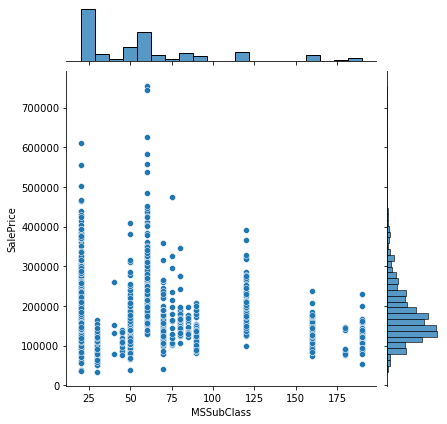

<Figure size 1440x1800 with 0 Axes>

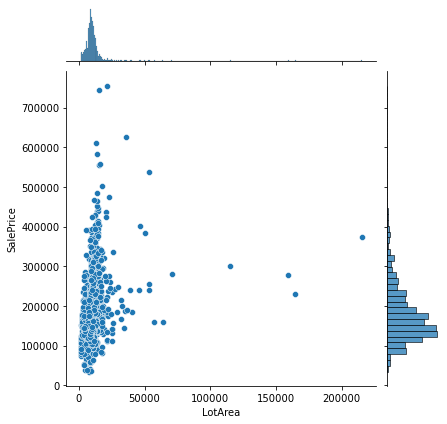

<Figure size 1440x1800 with 0 Axes>

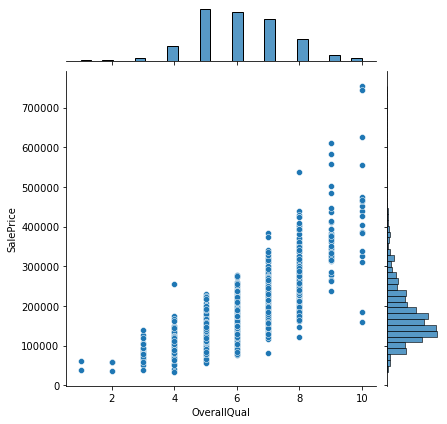

<Figure size 1440x1800 with 0 Axes>

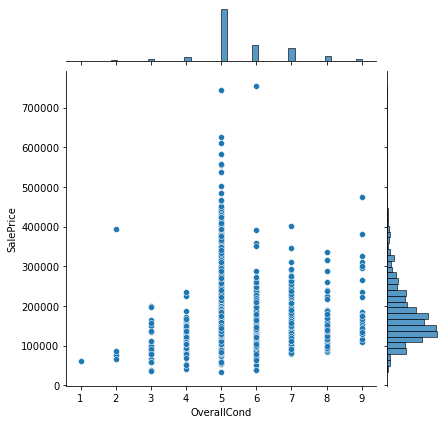

<Figure size 1440x1800 with 0 Axes>

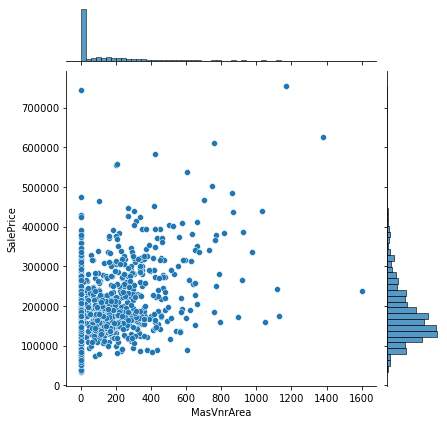

<Figure size 1440x1800 with 0 Axes>

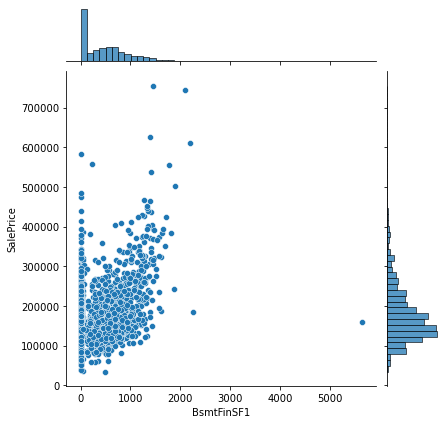

<Figure size 1440x1800 with 0 Axes>

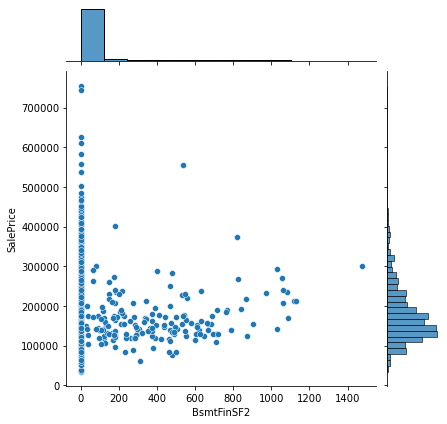

<Figure size 1440x1800 with 0 Axes>

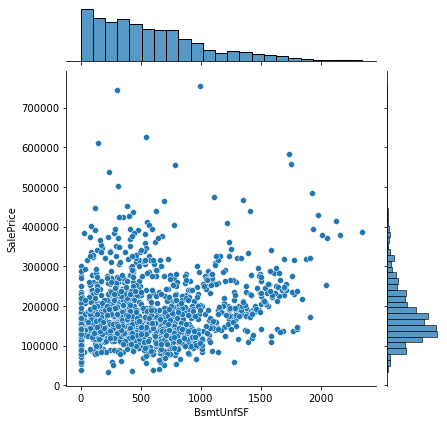

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

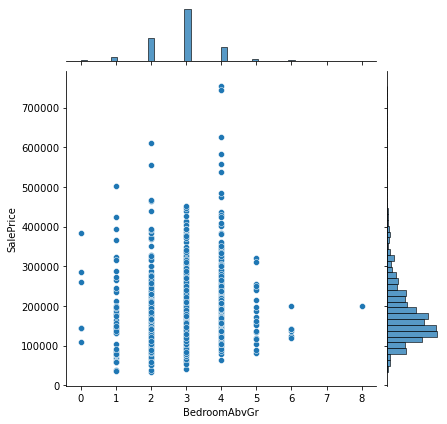

<Figure size 1440x1800 with 0 Axes>

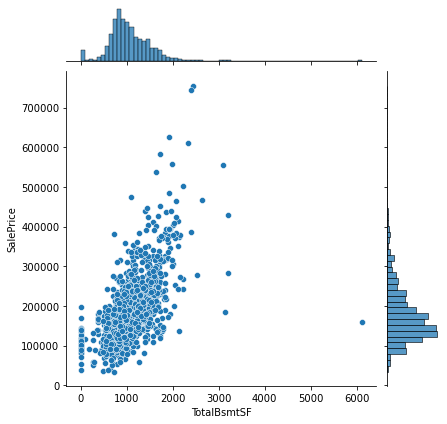

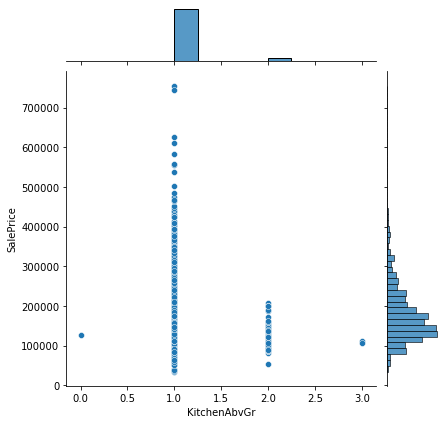

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

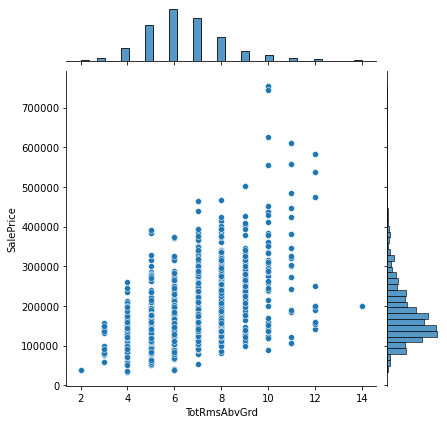

<Figure size 1440x1800 with 0 Axes>

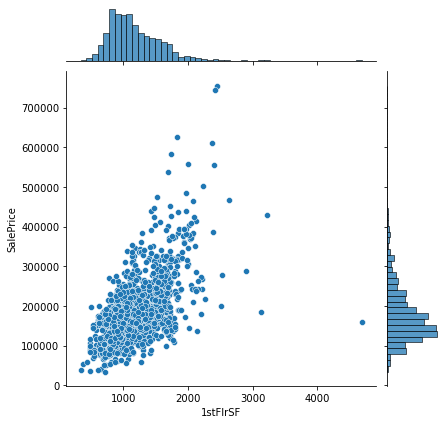

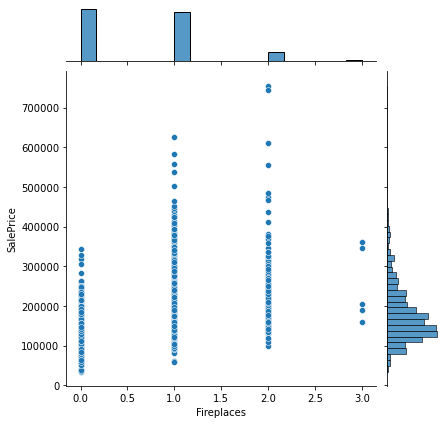

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

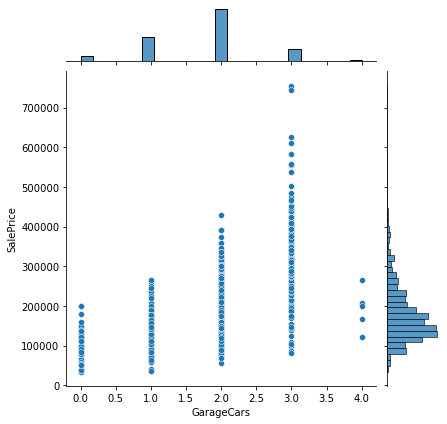

<Figure size 1440x1800 with 0 Axes>

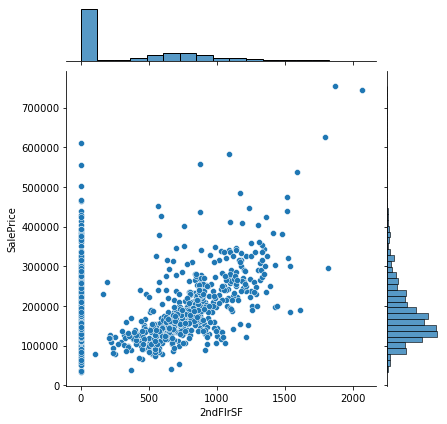

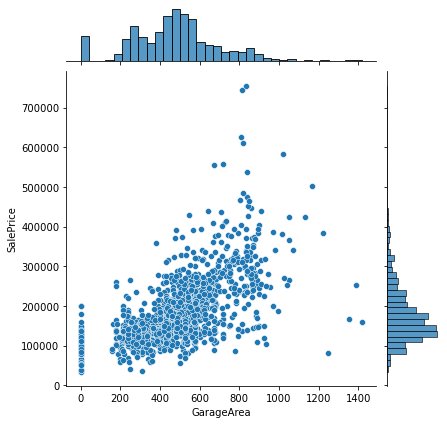

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

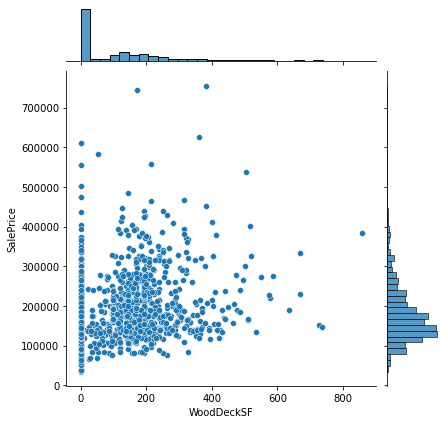

<Figure size 1440x1800 with 0 Axes>

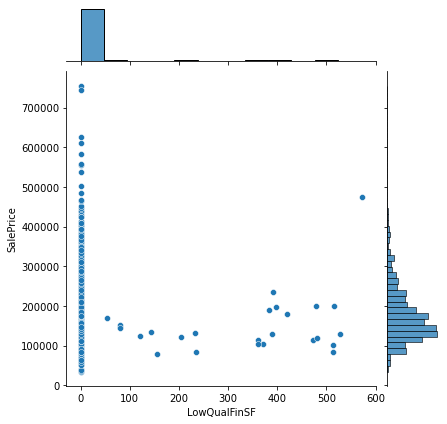

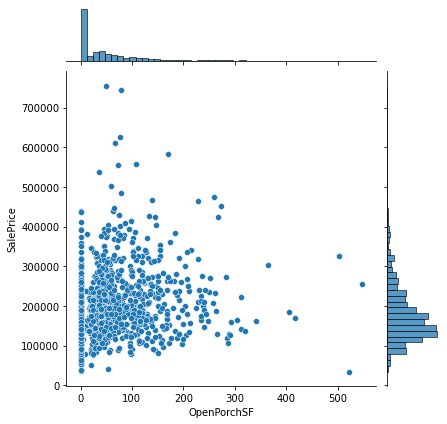

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

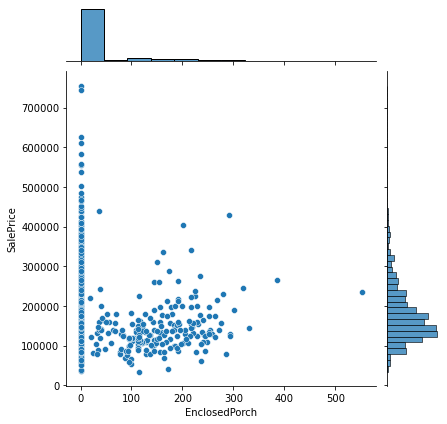

<Figure size 1440x1800 with 0 Axes>

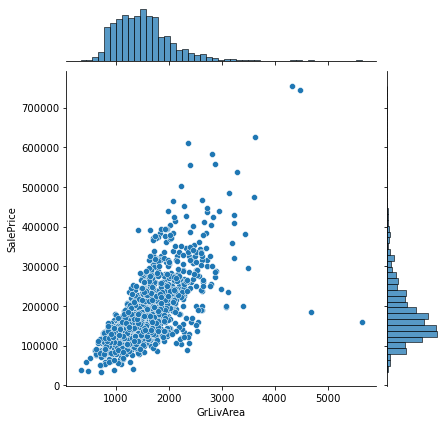

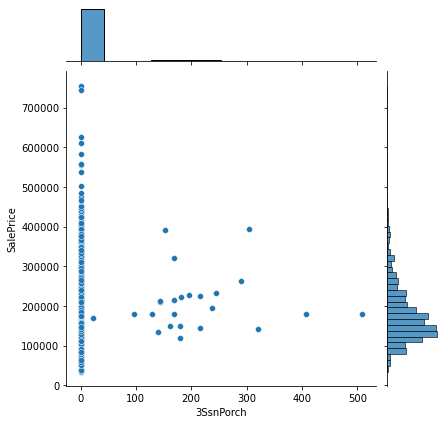

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

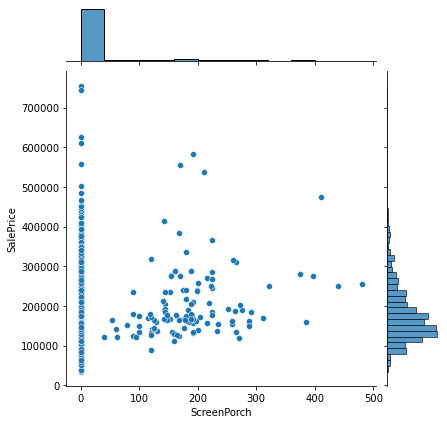

<Figure size 1440x1800 with 0 Axes>

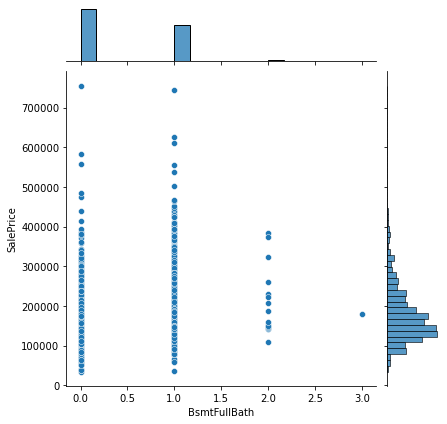

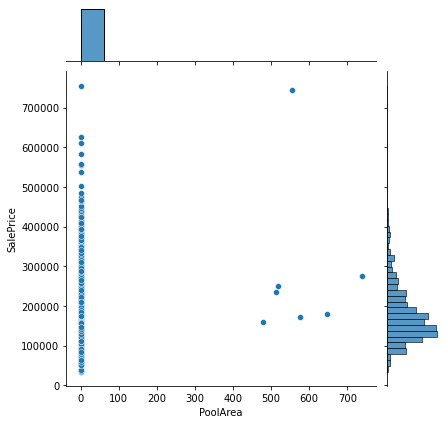

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

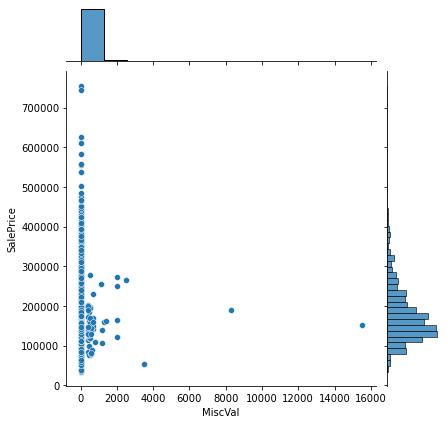

<Figure size 1440x1800 with 0 Axes>

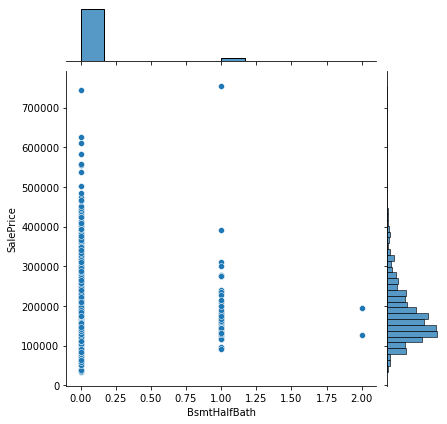

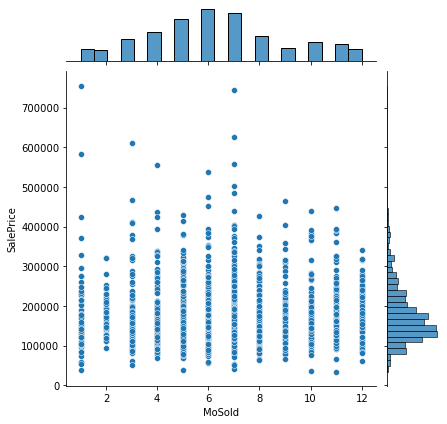

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

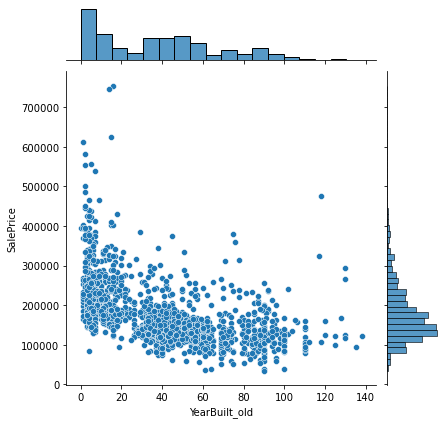

<Figure size 1440x1800 with 0 Axes>

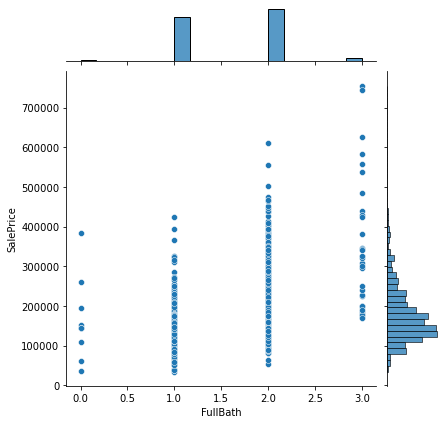

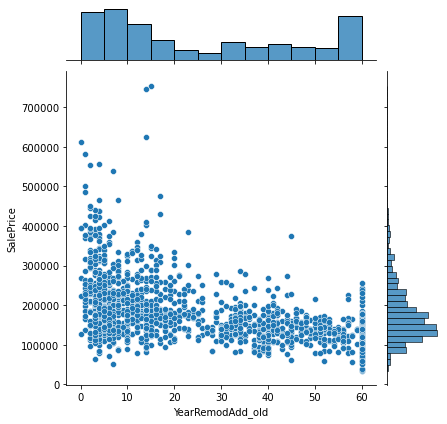

<Figure size 1440x1800 with 0 Axes>

<Figure size 1440x1800 with 0 Axes>

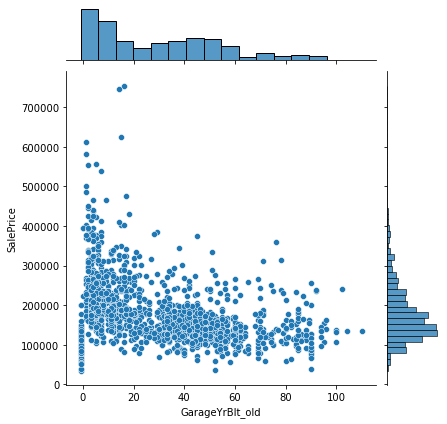

<Figure size 1440x1800 with 0 Axes>

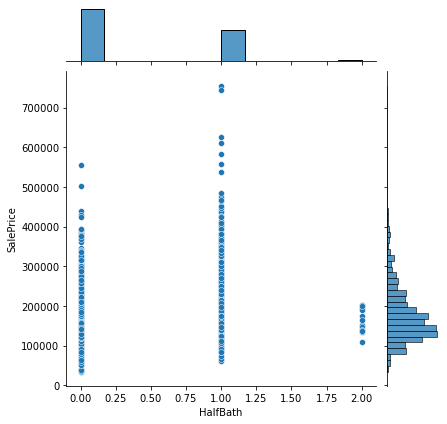

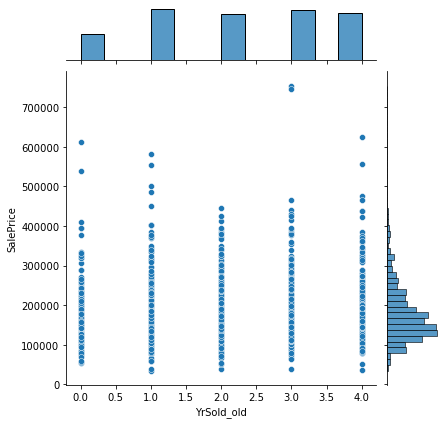

In [35]:
## Plots for numerical variables
for index, col in enumerate(numerical_columns):
    numcoldata(Housing_data,index,col,'SalePrice')

<Figure size 432x288 with 0 Axes>

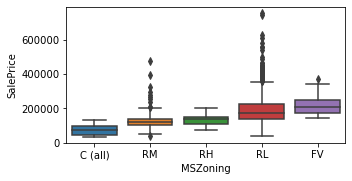

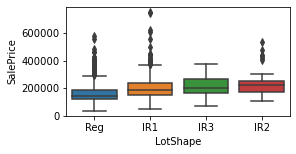

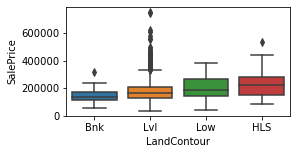

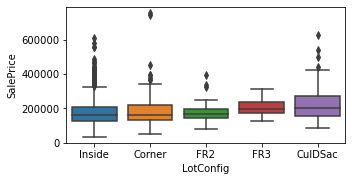

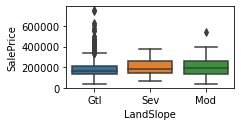

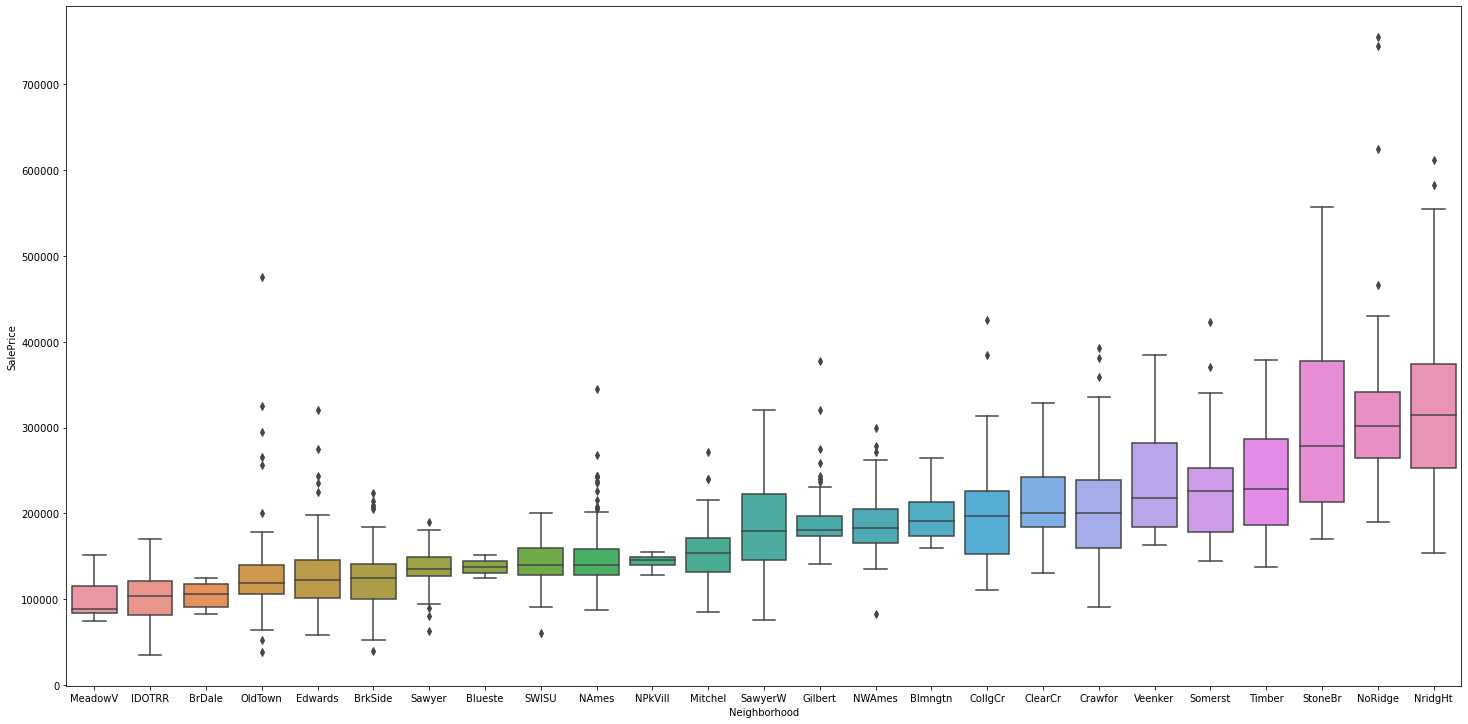

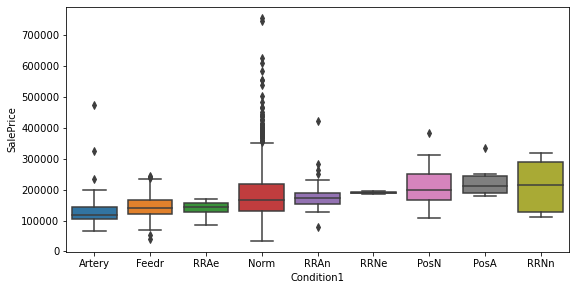

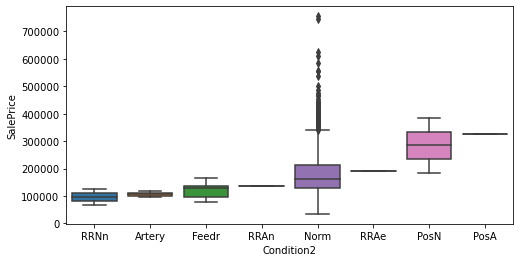

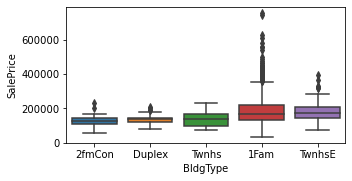

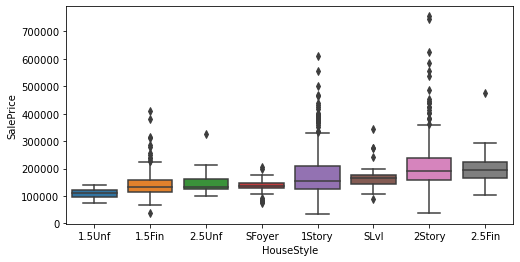

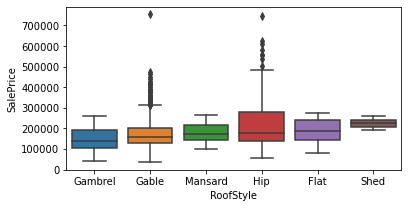

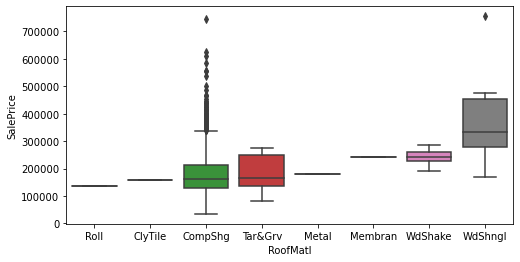

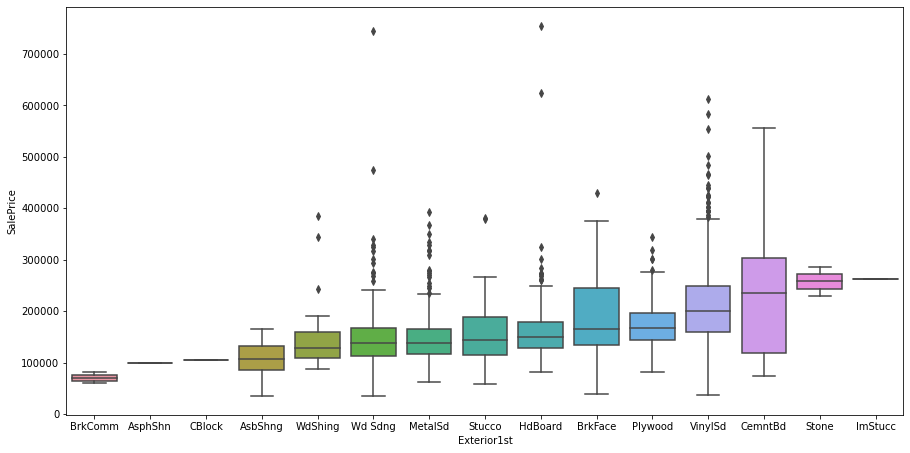

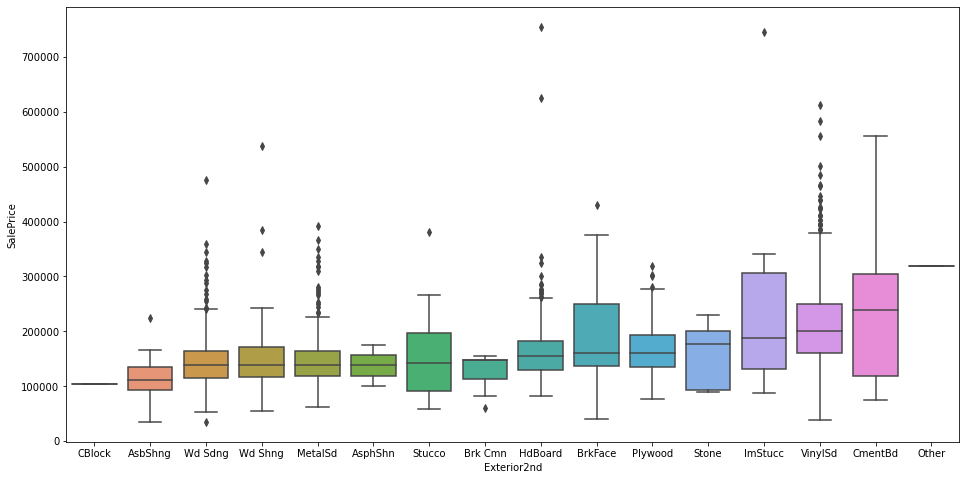

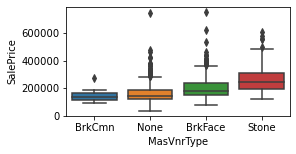

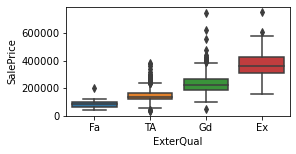

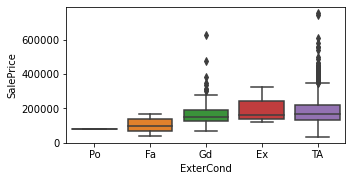

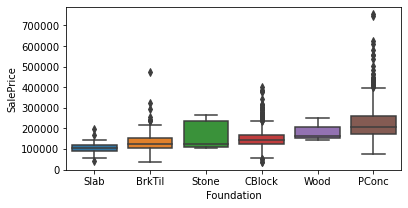

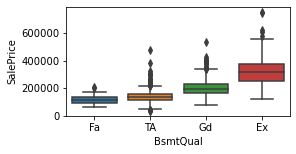

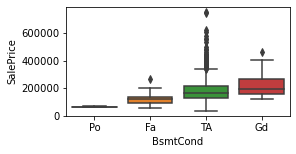

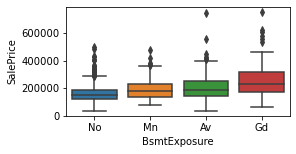

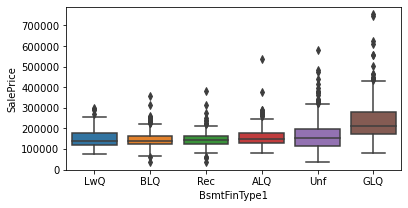

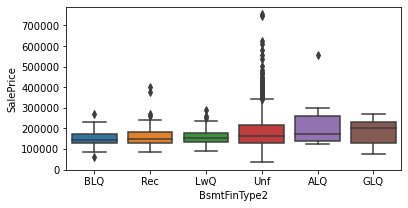

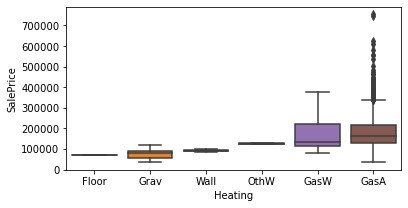

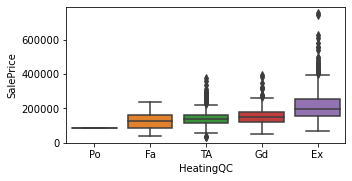

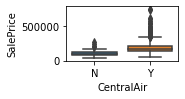

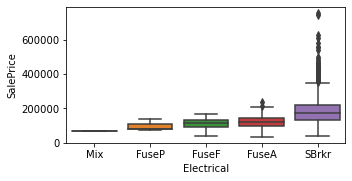

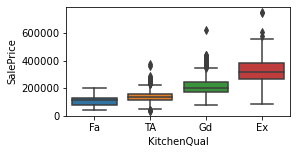

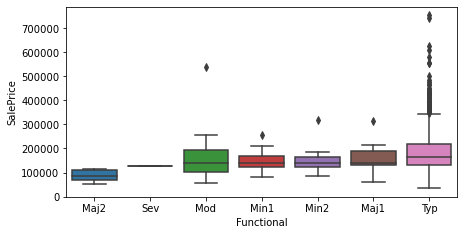

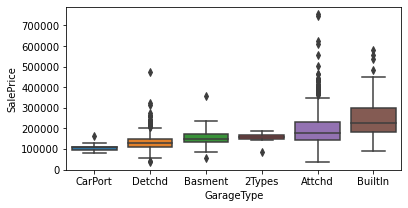

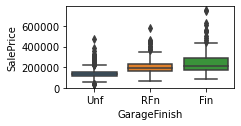

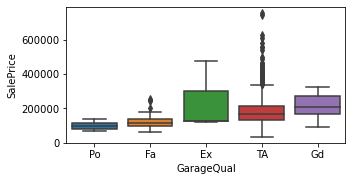

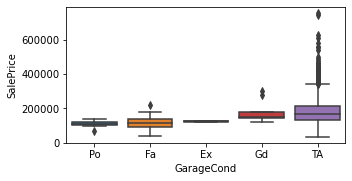

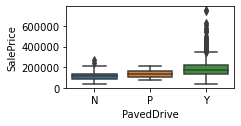

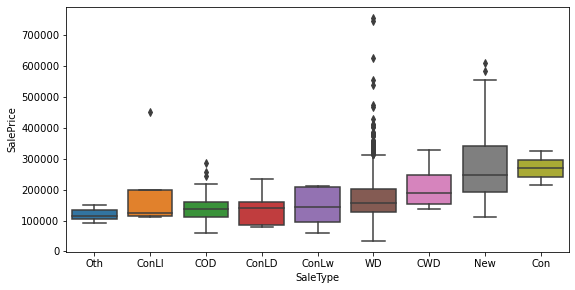

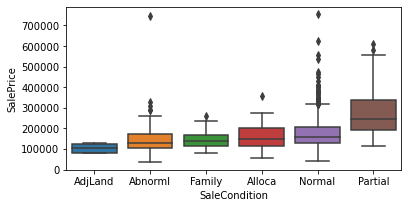

In [36]:
# Box Plots for the catorical variables 
for index , col in enumerate(categorical_variables):
    categorycoldata(Housing_data,index,col,'SalePrice')

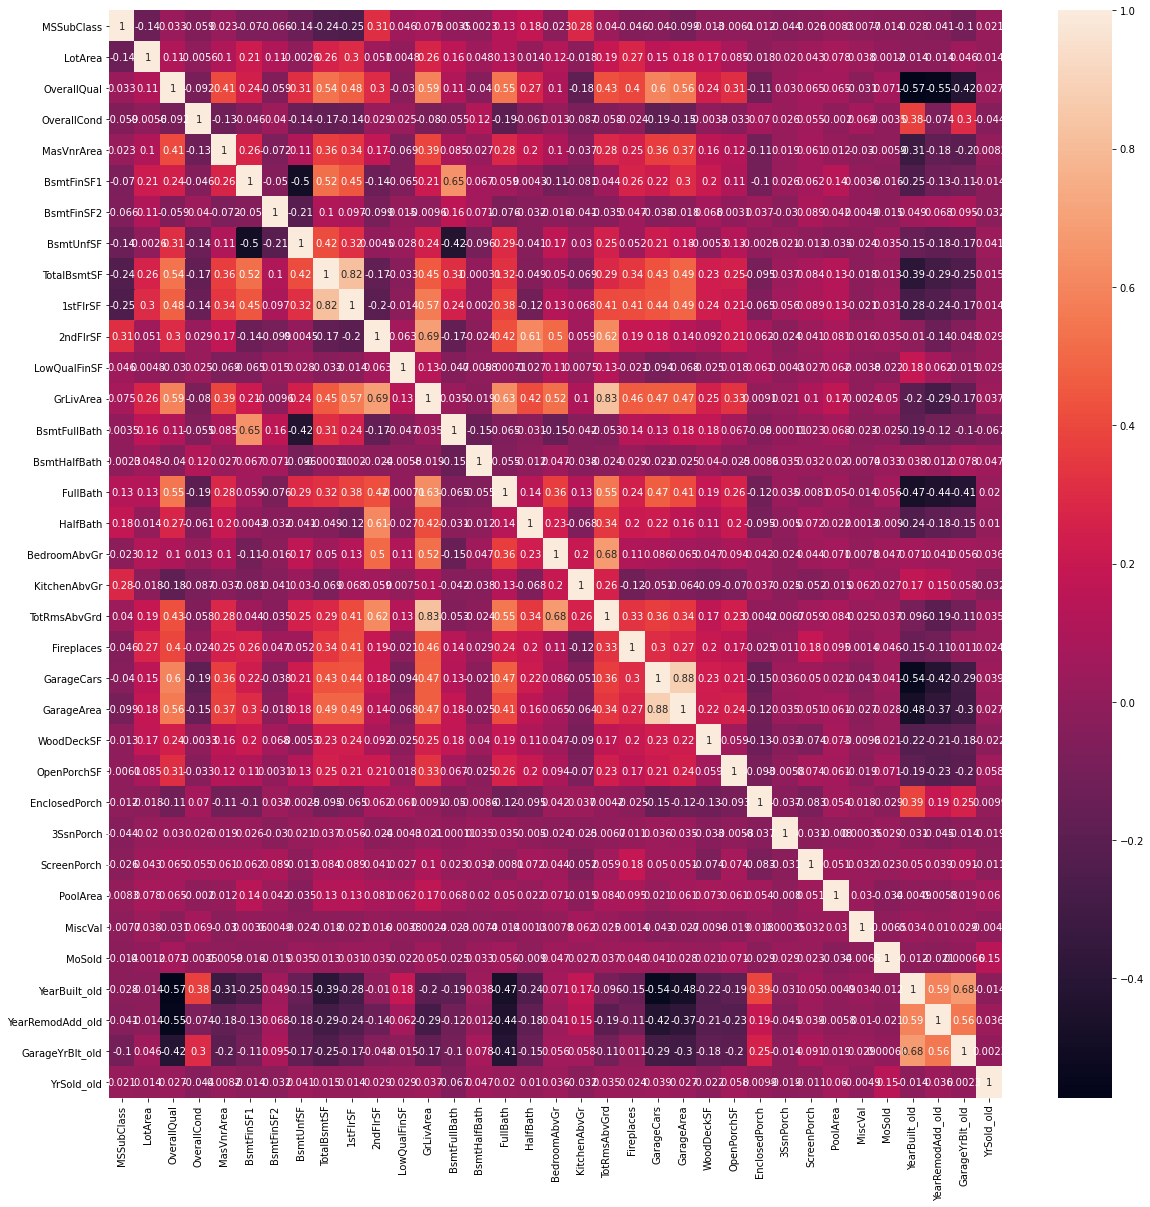

In [37]:
## Generate the Heat map and coeficients for the data 
plt.figure(figsize=(20,20))
sns.heatmap(Housing_data[numerical_columns].corr(),annot=True)
plt.show()

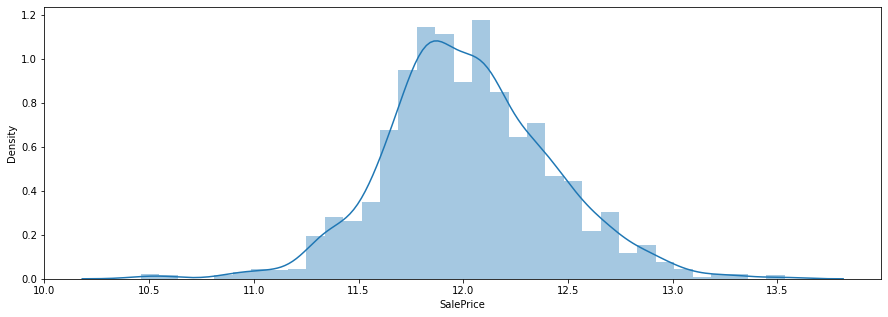

In [39]:
## To see how sale distribution and skewness using the logs
plt.figure(figsize=(15,5))
sns.distplot(np.log(Housing_data['SalePrice']))
plt.show()

# 2. Start Preparing the data for modelling

In [40]:
Housing_data.shape

(1460, 72)

In [41]:
## Drop the outliers 
numerical_columns = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
Housing_data = dropOutliers(Housing_data,numerical_columns)

In [42]:
Housing_data.shape

(1441, 72)

In [43]:
## There are 36 categorical variables to be converted into numerical terms
Housing_data[categorical_variables].shape

(1441, 36)

In [44]:
##Out of 36 categorical variables there certain variables which follow the order and sequence with specific number 
###and we can convert the using the map function
order_columns = ['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']
Housing_data[order_columns].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


In [45]:
# Use of map function to convert them into numerical factors
Housing_data[order_columns[0]] = Housing_data[order_columns[0]].map({'Gtl':0,'Mod':1,'Sev':2})
Housing_data[order_columns[1]] = Housing_data[order_columns[1]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
Housing_data[order_columns[2]] = Housing_data[order_columns[2]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
Housing_data[order_columns[3]] = Housing_data[order_columns[3]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
Housing_data[order_columns[4]] = Housing_data[order_columns[4]].map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
Housing_data[order_columns[5]] = Housing_data[order_columns[5]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
Housing_data[order_columns[6]] = Housing_data[order_columns[6]].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
Housing_data[order_columns[7]] = Housing_data[order_columns[7]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
Housing_data[order_columns[8]] = Housing_data[order_columns[8]].map({'N':0,'Y':1})
Housing_data[order_columns[9]] = Housing_data[order_columns[9]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
Housing_data[order_columns[10]] = Housing_data[order_columns[10]].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
Housing_data[order_columns[11]] = Housing_data[order_columns[11]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
Housing_data[order_columns[12]] = Housing_data[order_columns[12]].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
Housing_data[order_columns[13]] = Housing_data[order_columns[13]].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
Housing_data[order_columns[14]] = Housing_data[order_columns[14]].map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [46]:
Housing_data[order_columns].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


## getting the Dummies for the variables

In [47]:
get_dummy = pd.get_dummies(Housing_data[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],drop_first = True)

In [48]:
## Concating the data and dropping the categorucal columns 
Housing_data = pd.concat([Housing_data,get_dummy],axis='columns')
Housing_data = Housing_data.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis ='columns')

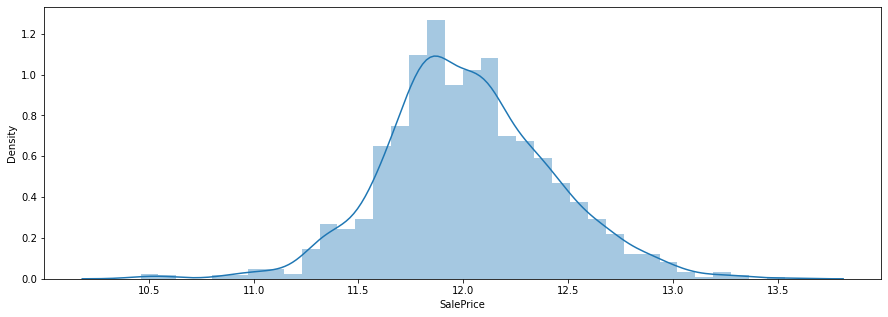

In [49]:
## Let us see the sales prices 
plt.figure(figsize=(15,5))
sns.distplot(np.log(Housing_data.SalePrice))
plt.show()

In [50]:
## Now Let us see the data
Housing_data.head()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_old,YearRemodAdd_old,GarageYrBlt_old,YrSold_old,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,3,0,7,5,196.0,3,2,4,3,1,6,706,1,0,150,856,4,1,856,854,0,1710,1,0,2,1,3,1,3,8,0,2,2,548,3,3,0,61,0,0,0,0,0,2,208500,7,7,7.0,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,9600,3,0,6,8,0.0,2,2,4,3,4,5,978,1,0,284,1262,4,1,1262,0,0,1262,0,1,2,0,3,1,2,6,1,2,2,460,3,3,298,0,0,0,0,0,0,5,181500,34,34,34.0,3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,11250,0,0,7,5,162.0,3,2,4,3,2,6,486,1,0,434,920,4,1,920,866,0,1786,1,0

In [51]:
## Now Splitting the data into Train and test split  and we will consider random only 50%
Housing_data_train,Housing_data_test = train_test_split(Housing_data,train_size=0.7,test_size=0.3,random_state= 50)

In [52]:
### Now Doing the scaling of Numerical values
numerical_columns = Housing_data.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
Housing_data_train[numerical_columns] = scaler.fit_transform(Housing_data_train[numerical_columns])
Housing_data_test[numerical_columns] = scaler.fit_transform(Housing_data_test[numerical_columns])


In [53]:
Housing_data_train.head()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_old,YearRemodAdd_old,GarageYrBlt_old,YrSold_old,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1311,-0.89,-0.24,0.76,-0.23,0.67,-0.54,-0.15,1.11,-0.24,0.67,-0.03,-0.64,1.17,1.09,-0.32,-0.28,-0.50,0.53,0.89,0.26,0.29,-0.81,-0.12,-0.49,1.14,-0.24,0.83,-0.77,0.14,-0.21,0.75,-0.34,-0.95,0.3,0.29,0.15,0.13,0.12,1.39,0.76,-0.38,-0.11,-0.26,0.0,-0.15,-2.00,0.28,-1.13,-1.09,-1.01,0.60,-0.21,-0.11,0.52,-0.42,-0.18,-0.15,0.32,-0.27,-0.18,-0.05,0.63,-0.03,-0.09,-0.21,-0.14,3.08,-0.19,-0.25,-0.23,-0.16,-0.1,-0.21,-0.44,-0.05,-0.22,-0.18,-0.25,-0.29,-0.13,-0.24,-0.23,-0.24,-0.13,-0.16,-0.09,-0.25,0.4,-0.07,-0.11,-0.1,-0.13,-0.04,-0.06,-0.07,0.11,0.0,-0.04,-0.03,-0.04,-0.13,-0.2,-0.17,-0.27,-0.09,1.03,-0.06,-0.08,-0.67,-0.17,-0.23,0.53,-0.09,-0.49,-0.08,0.0,-0.03,0.0,0.0,-0.09,-0.06,-0.05,-0.03,-0.04,-0.18,0.0,-0.2,-0.44,-0.03,-0.42,-0.28,-0.03,-0.12,1.37,-0.41,-0.14,-0.05,-0.06,-0.13,0.0,-0.2,-0.42,-0.08,-0.41,-0.03,-0.33,-0.05,-0.13,1.39,-0.4,-0.17,1.48,-1.20,-0.31,-0.89,1.13,-0.12,-0.07,-0.04,0.15,-0.11,-0.07,

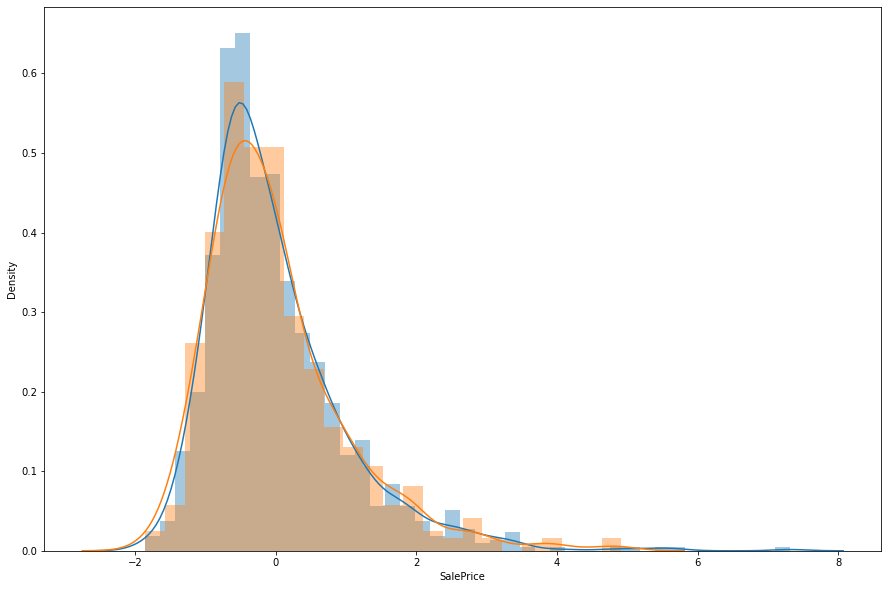

In [54]:
# Lets see how train and test Sales prices
plt.figure(figsize=(15,10))
sns.distplot(Housing_data_train['SalePrice'])
sns.distplot(Housing_data_test['SalePrice'])
plt.show()
## We see there is skewness in the right side of data

In [55]:
y_train = Housing_data_train.pop('SalePrice')
X_train = Housing_data_train

In [56]:
y_test = Housing_data_test.pop('SalePrice')
X_test = Housing_data_test

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1008, 193)
(433, 193)
(1008,)
(433,)


In [58]:
###Building the model and Using the RFE to take top priority features
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [59]:
y_train_predict = lm.predict(X_train)
y_test_predict = lm.predict(X_test)

In [60]:
print ('r2 score of train data set :',(r2_score(y_train,y_train_predict)))
print ('r2 score of test  data set :',(r2_score(y_test,y_test_predict)))

r2 score of train data set : 0.9215572978890438
r2 score of test  data set : -1.9756741252920487e+21


In [61]:
## Lets Define the variables inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [72]:
# recursive Feature elimination and take top 50
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=70)

In [73]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))

In [74]:
rfe_scores.columns = ['Column_names','Status','Rank']

In [75]:
rfe_select_columns = list(rfe_scores[rfe_scores.Status==True].Column_names)
rfe_select_columns

['LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'PoolArea',
 'YearBuilt_old',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotConfig_CulDSac',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'RoofStyle_Shed',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_Wd Sdng',
 'Exterior2nd_CBlock',
 'Exterior2nd_CmentBd',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd

In [76]:
X_train = X_train[rfe_select_columns]
X_test  = X_test[rfe_select_columns]

In [77]:
###Use of Lasso to fetch the data and use Alpha as 0.01
lm = Lasso(alpha=0.01)
lm.fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_predict))
y_test_predict = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_predict))

0.9006890867909132
0.9024930072248007


In [78]:
model_params = list(lm.coef_)
model_params.insert(0,lm.intercept_)
model_params = [round(x,3) for x in model_params]
col = Housing_data_train.columns
col.insert(0,'Constant')
list(zip(col,model_params))

[('MSSubClass', 0.0),
 ('LotArea', 0.027),
 ('LotShape', 0.165),
 ('LandSlope', 0.06),
 ('OverallQual', 0.07),
 ('OverallCond', 0.086),
 ('MasVnrArea', 0.069),
 ('ExterQual', 0.056),
 ('ExterCond', 0.116),
 ('BsmtQual', 0.008),
 ('BsmtCond', -0.0),
 ('BsmtExposure', 0.063),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinType2', -0.013),
 ('BsmtFinSF2', 0.315),
 ('BsmtUnfSF', -0.021),
 ('TotalBsmtSF', -0.037),
 ('HeatingQC', 0.05),
 ('CentralAir', 0.039),
 ('1stFlrSF', 0.035),
 ('2ndFlrSF', 0.029),
 ('LowQualFinSF', 0.051),
 ('GrLivArea', 0.0),
 ('BsmtFullBath', -0.047),
 ('BsmtHalfBath', 0.02),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.017),
 ('KitchenAbvGr', 0.019),
 ('KitchenQual', 0.001),
 ('TotRmsAbvGrd', 0.023),
 ('Fireplaces', 0.028),
 ('GarageFinish', 0.067),
 ('GarageCars', 0.096),
 ('GarageArea', 0.057),
 ('GarageQual', 0.026),
 ('GarageCond', 0.0),
 ('WoodDeckSF', -0.102),
 ('OpenPorchSF', -0.042),
 ('EnclosedPorch', -0.047),
 ('3SsnPorch', 0.024),

In [79]:
## Lets try with different Alpha values
folds = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_parameters = {'alpha' :[0.001,0.01,0.1,1.0,5.0,10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator=model,param_grid=hyper_parameters,scoring='r2',cv=folds,verbose=1,return_train_score=True,n_jobs= -1)
model_cv.fit(X_train,y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=50, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [80]:
# Lets see the summary of data
cv_results1 = pd.DataFrame(model_cv.cv_results_)
cv_results1['param_alpha'] = cv_results1['param_alpha'].astype('float32')
cv_results1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.06,5.44e-03,5.83e-03,7.63e-04,1.00e-03,{'alpha': 0.001},0.84,5.80e-01,9.13e-01,0.87,9.06e-01,8.89e-01,0.69,9.13e-01,9.21e-01,0.89,0.84,0.11,1,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.38e-03
1,0.02,4.28e-03,6.27e-03,6.98e-04,1.00e-02,{'alpha': 0.01},0.82,6.58e-01,9.23e-01,0.85,8.95e-01,8.87e-01,0.66,9.00e-01,9.24e-01,0.89,0.84,0.09,2,0.90,0.91,0.90,0.90,0.90,0.90,0.91,0.90,0.90,0.90,0.90,5.10e-03
2,0.01,1.16e-03,6.31e-03,1.38e-03,1.00e-01,{'alpha': 0.1},0.75,8.85e-01,8.89e-01,0.77,8.13e-01,8.08e-01,0.63,8.22e-01,8.74e-01,0.82,0.81,0.07,3,0.83,0.82,0.81,0.82,0.82,0.82,0.84,0.81,0.81,0.81,0.82,9.51e-03
3,0.01,2.57e-03,7.45e-03,2.51e-03,1.00e+00,{'alpha': 1.0},-0.07,-9.83e-03,-1.24e-03,-0.05,-1.95e-03,-1.14e-03,-0.03,-2.56e-03,-6.06e-05,-0.07,-0.02,0.03,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00
4,0.01,1.53e-03,7.26e-03,2.03e-03,5.00e+00,{'alpha': 5.0},-0.07,-9.83e-03,-1.24e-03,-0.05,-1.95e-03,-1.14e-03,-0.03,-2.56e-03,-6.06e-05,-0.07,-0.02,0.03,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00


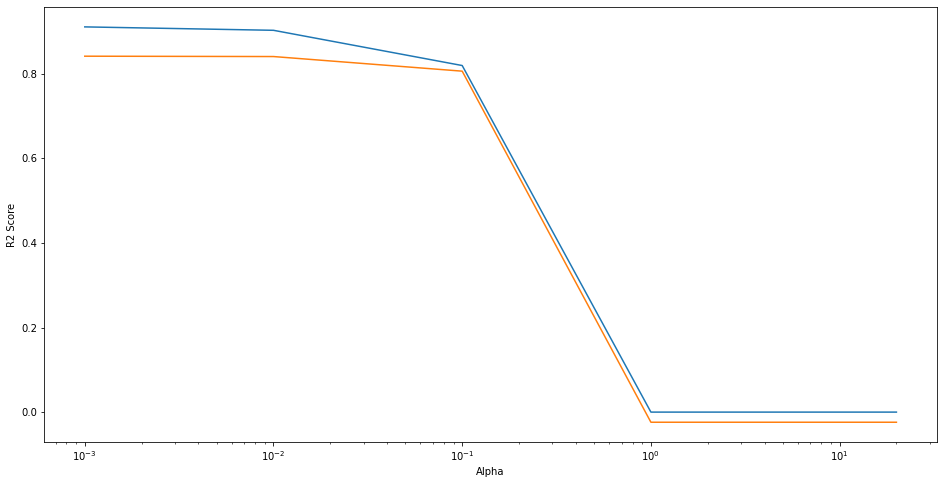

In [81]:
plt.figure(figsize=(16,8))
plt.plot(cv_results1['param_alpha'],cv_results1['mean_train_score'])
plt.plot(cv_results1['param_alpha'],cv_results1['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [82]:
lasso_alpha = model_cv.best_params_

In [83]:
print(lasso_alpha)

{'alpha': 0.001}


In [84]:
###Use of Lasso to fetch the data and use Alpha as 0.001
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)
y_train_predict = lasso.predict(X_train)
Lasso_train_Score = (r2_score(y_true=y_train,y_pred=y_train_predict))
y_test_predict = lasso.predict(X_test)
Lasso_test_Score = (r2_score(y_true=y_test,y_pred=y_test_predict))

In [85]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = Housing_data_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [86]:
lasso_parameters_final = lasso_coef.sort_values(by='Coef',ascending=False).head(10)

In [87]:
## Use of Ridge to see the coeficients
###Use of Lasso to fetch the data and use Alpha as 0.001
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)
y_train_predict = ridge.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_predict))
y_test_predict = ridge.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_predict))

0.9091423024548035
0.8962749605335112


In [88]:
###Lets use different paramters of alpha to best identify the one

folds = KFold(n_splits=10,shuffle=True,random_state=50)

hyper_parameters = {'alpha' :[0.001,0.01,0.1,1.0,5.0,10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,param_grid=hyper_parameters,scoring='r2',cv=folds,verbose=1,return_train_score=True,n_jobs= -1)
model_cv.fit(X_train,y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=50, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [89]:
# Lets see the summary of data
cv_results1 = pd.DataFrame(model_cv.cv_results_)
cv_results1['param_alpha'] = cv_results1['param_alpha'].astype('float32')
cv_results1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,9.61e-03,1.01e-03,4.98e-03,5.27e-04,1.00e-03,{'alpha': 0.001},0.84,0.57,0.91,0.87,0.91,0.89,0.67,0.91,0.92,0.89,0.84,0.11,7,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.48e-03
1,1.20e-02,7.91e-03,5.11e-03,7.15e-04,1.00e-02,{'alpha': 0.01},0.84,0.57,0.91,0.87,0.91,0.89,0.67,0.91,0.92,0.89,0.84,0.11,6,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.48e-03
2,1.88e-02,1.71e-02,5.48e-03,6.73e-04,1.00e-01,{'alpha': 0.1},0.84,0.57,0.91,0.87,0.91,0.89,0.67,0.91,0.92,0.89,0.84,0.11,5,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.48e-03
3,1.00e-02,1.11e-03,6.40e-03,1.92e-03,1.00e+00,{'alpha': 1.0},0.84,0.57,0.91,0.87,0.91,0.89,0.68,0.91,0.92,0.89,0.84,0.11,4,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.47e-03
4,1.05e-02,2.27e-03,7.32e-03,2.38e-03,5.00e+00,{'alpha': 5.0},0.84,0.58,0.91,0.87,0.91,0.89,0.69,0.91,0.92,0.89,0.84,0.11,3,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.91,0.91,5.39e-03


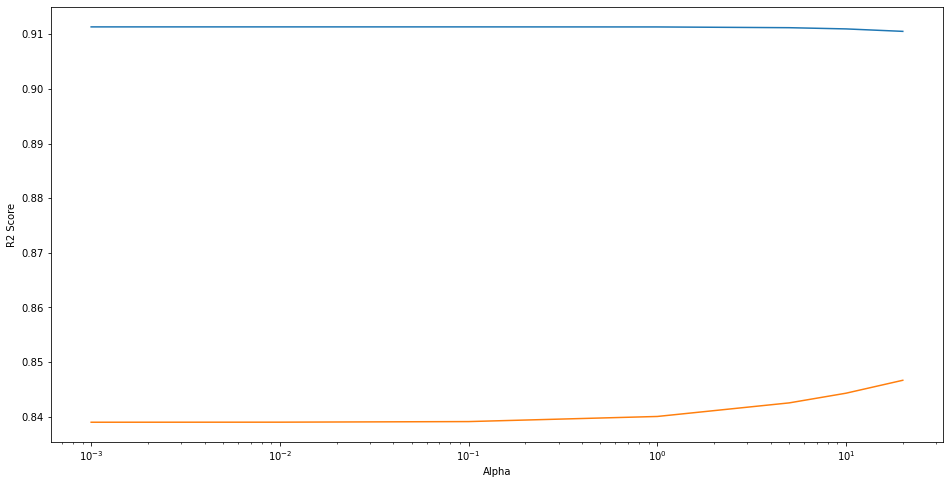

In [90]:
plt.figure(figsize=(16,8))
plt.plot(cv_results1['param_alpha'],cv_results1['mean_train_score'])
plt.plot(cv_results1['param_alpha'],cv_results1['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [91]:
Ridge_alpha =  model_cv.best_params_

In [92]:
print(Ridge_alpha)

{'alpha': 20.0}


In [93]:
## Caluclation Alpha value = 20
ridge = Ridge(alpha=20.0)
ridge.fit(X_train,y_train)
y_train_predict = ridge.predict(X_train)
Ridge_train_Score = (r2_score(y_true=y_train,y_pred=y_train_predict))
y_test_predict = ridge.predict(X_test)
Ridge_test_Score = (r2_score(y_true=y_test,y_pred=y_test_predict))

In [94]:
## Lets see the Coeficients and constants
model_param = list(ridge.coef_)
model_param.insert(0,ridge.intercept_)
cols = Housing_data_train.columns
cols.insert(0,'const')
ridge_coef = pd.DataFrame(list(zip(cols,model_param)))
ridge_coef.columns = ['Featuere','Coef']

In [99]:
Ridge_parameters_final = ridge_coef.sort_values(by='Coef',ascending=False).head(10)

In [96]:
ridge_coef.sort_values(by= 'Coef',ascending=False).head(10)

,Featuere,Coef
15,BsmtFinSF2,0.18
13,BsmtFinSF1,0.15
2,LotShape,0.15
34,GarageCars,0.11
8,ExterCond,0.10
68,Neighborhood_Gilbert,0.09
11,BsmtExposure,0.09
4,OverallQual,0.09
19,CentralAir,0.08
33,GarageFinish,0.08


### Details of R2 scores and best aplha values of Ridge and Lasso and coeficients

In [101]:
## Final Conslusion is Lasso model both training and test accuracy close.
print('Ridge Accuracy score of Train Data set :',round(Ridge_train_Score,3))
print ('Ridge Accuracy score of Test Data set :',round(Ridge_test_Score,3))
print ('Lasso Accuracy score of Test Data set :',round(Lasso_train_Score,3))
print ('Lasso Accuracy score of Test Data set :',round(Lasso_test_Score,3))
print ('best lasso alpha Value :',lasso_alpha)
print ('best Ridge alpha value :',Ridge_alpha)
print('Final parameters of Lasso',lasso_parameters_final)
print('Final parameters of Ridge',Ridge_parameters_final)

Ridge Accuracy score of Train Data set : 0.909
Ridge Accuracy score of Test Data set : 0.899
Lasso Accuracy score of Test Data set : 0.909
Lasso Accuracy score of Test Data set : 0.9
best lasso alpha Value : {'alpha': 0.001}
best Ridge alpha value : {'alpha': 20.0}
Final parameters of Lasso                 Featuere  Coef
15            BsmtFinSF2  0.30
2               LotShape  0.15
8              ExterCond  0.12
34            GarageCars  0.11
68  Neighborhood_Gilbert  0.09
4            OverallQual  0.08
33          GarageFinish  0.08
19            CentralAir  0.07
13            BsmtFinSF1  0.07
52           MSZoning_RL  0.07
Final parameters of Ridge                 Featuere  Coef
15            BsmtFinSF2  0.18
13            BsmtFinSF1  0.15
2               LotShape  0.15
34            GarageCars  0.11
8              ExterCond  0.10
68  Neighborhood_Gilbert  0.09
11          BsmtExposure  0.09
4            OverallQual  0.09
19            CentralAir  0.08
33          GarageFinish  0.08


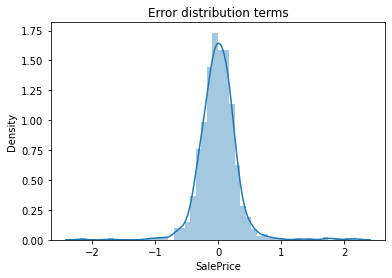

In [105]:
# Lets check the residuals and error terms and we can see there is not skewness in the data and data is normally distributed
## residuals on Training data
sns.distplot(y_train-y_train_predict)
plt.title('Error distribution terms')
plt.show()

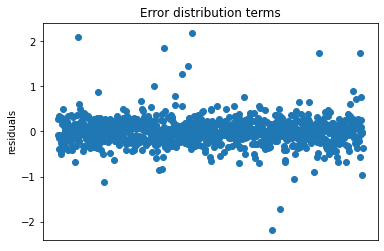

In [106]:
## Checking for Heteroscendinity and Homescenecity
x = [i for i in range (1,y_train.shape[0]+1,1)]
plt.scatter(x,y_train-y_train_predict)
plt.title('Error distribution terms')
plt.ylabel('residuals')
plt.xticks([])
plt.show()

## There is no heteroscedasicity in residuals

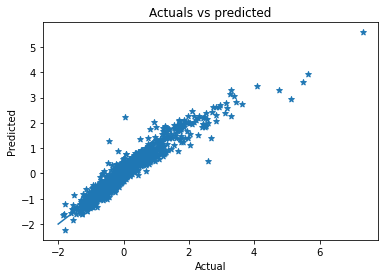

In [110]:
plt.plot([-2,2],[-2,2],label ='Actual')
plt.scatter(y_train,y_train_predict,marker='*')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actuals vs predicted')
plt.show()

# We can see linear relation ship in the data 

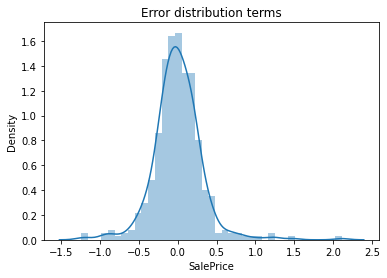

In [111]:
## Test Data 
# residuals on test data 
sns.distplot(y_test-y_test_predict)
plt.title('Error distribution terms')
plt.show()

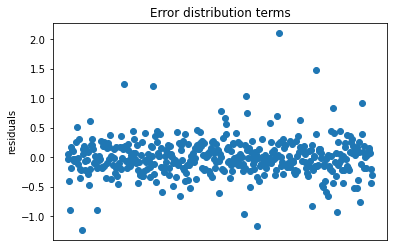

In [114]:
## Error terms distribution on test data 
x = [i for i in range (1,y_test.shape[0]+1,1)]
plt.scatter(x,y_test-y_test_predict)
plt.title('Error distribution terms')
plt.ylabel('residuals')
plt.xticks([])
plt.show()

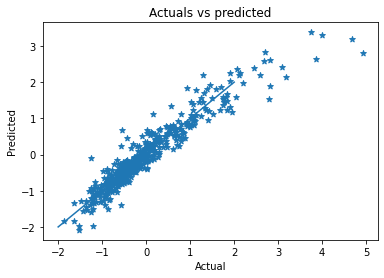

In [115]:
## Actual vs predicted on test data set
plt.plot([-2,2],[-2,2],label ='Actual')
plt.scatter(y_test,y_test_predict,marker='*')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actuals vs predicted')
plt.show()

In [121]:
print(lasso.intercept_)
print(lasso_parameters_final)

5.267860711745585e-17
                Featuere  Coef
15            BsmtFinSF2  0.30
2               LotShape  0.15
8              ExterCond  0.12
34            GarageCars  0.11
68  Neighborhood_Gilbert  0.09
4            OverallQual  0.08
33          GarageFinish  0.08
19            CentralAir  0.07
13            BsmtFinSF1  0.07
52           MSZoning_RL  0.07


# Variables predicting the price
BsmtFinSF2 : Type 2 finished square feet.
LotShape : General shape of property.
ExterCond : Evaluates the present condition of the material on the exterior.
GarageCars : Size of garage in car capacity.
Neighborhood_Gilbert : Physical locations within Ames city limits(Gilbert).
BsmtFinSF1 : Type 1 finished square feet.
OverallQual : Rates the overall material and finish of the house.
BsmtExposure : Refers to walkout or garden level walls.
CentralAir : Central air conditioning.
OverallCond : Rates the overall condition of the house.